### 1. Read and explore the data

#### 1.1 Import Python module

In [1]:
# https://ai.plainenglish.io/best-performance-tuning-practices-for-pytorch-3ef06329d5fe
import gc
import time
import os
import cv2
import shutil
import random
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision import models
from torch import optim
from sklearn.metrics import *
from sklearn.model_selection import KFold

seed = 24
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

num_workers = 4
batch_size = 16
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
categories = ['COVID19', 'NORMAL', 'PNEUMONIA']
num_classes = len(categories)
splits = ['train', 'val', 'test']
DATA_PATH = r"C:\Gunther\Datasets\Covid19DLH_80_10_10\Data"
model_path = r"C:\Gunther\OneDrive - University of Illinois - Urbana\Python\DLH\Project"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'You are using {device}')

You are using cuda


#### 1.2 Split original test folder equaly between test and validation (new) folders

In [6]:
if not os.path.isdir(os.path.join(DATA_PATH, 'val')):
    os.mkdir(os.path.join(DATA_PATH, 'val'))
    for subdir in categories:   
        for root, dirs, files in os.walk(os.path.join(DATA_PATH, 'test/'+subdir)):
            size = len(files)
            migrate_index = random.sample(range(size), int(size/2))
            files_to_migrate = [files[i] for i in migrate_index]
            for file in files_to_migrate:
                file_path = os.path.join(DATA_PATH, 'test/' + subdir + '/' + file)
                new_dir = os.path.join(DATA_PATH, 'val/' + subdir)
                if not os.path.exists(new_dir):
                    os.mkdir(new_dir)
                if not os.path.exists(os.path.join(new_dir, file)):
                    a = shutil.move(file_path, new_dir)
                    print('Folder test splitted successfully in two folders: test and val')
else: print("Folder 'val' was already available and the split didn't happened")

Folder 'val' was already available and the split didn't happened


#### 1.3 Explore dataset distribution among train, validation and test

In [2]:
def show_dataset(data_path=DATA_PATH):
    df = pd.DataFrame(columns = ['code'] + splits, index = categories)
    for row in categories:
        for col in splits:
            df.loc[row,col] = int(len(os.listdir(os.path.join(data_path, col+'/'+row))))
    df['total'] = df.sum(axis=1).astype(int)
    df.loc['TOTAL'] = df.sum(axis=0).astype(int)
    df['code'] = ['0', '1', '2','']
    print(df)
    return df

df_dataset = show_dataset()

          code train  val test  total
COVID19      0   460   58   58    576
NORMAL       1  1266  158  159   1583
PNEUMONIA    2  3418  427  428   4273
TOTAL           5144  643  645   6432


#### 1.4 (optional) Explore the size of all images (using parallel processing)

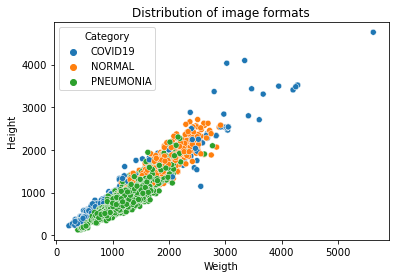

In [8]:
from dask.distributed import Client, LocalCluster  # !python -m pip install "dask[distributed]" --upgrade
def read_img_format(img_path):
    tmp = []
    img = cv2.imread(img_path)
    dataset = img_path.split('\\')[-3]
    category = img_path.split('\\')[-2]
    tmp.append((dataset, category, img.shape[0], img.shape[1]))
    return (dataset, category, img.shape[0], img.shape[1])

def img_formats():
    imgs = []
    for root, dirs, files in os.walk(DATA_PATH):
        for file in files:
            imgs.append(os.path.join(root, file))
    futures = []
    with LocalCluster(n_workers=int(0.9 * os.cpu_count()), processes=True, threads_per_worker=1,
                      memory_limit='4GB', ip='tcp://localhost:9895') as cluster, Client(cluster) as client:  
        for im in imgs:
            future = client.submit(read_img_format, im)
            futures.append(future)
        results = client.gather(futures)
    return pd.DataFrame(results, columns = ["Split", "Category",  "Height", "Weigth"])

df_formats = img_formats()
_ = sns.scatterplot(x = "Weigth", y = "Height", hue = "Category",
                    data = df_formats, legend = "brief").set_title('Distribution of image formats')

### 2. Data pre-processing (Augmentation + DataLoader)

In [3]:
def load_data(data_path=DATA_PATH, num_workers=num_workers):
    transform = transforms.Compose([transforms.Resize(250),
                                    transforms.CenterCrop(230),
                                    transforms.ToTensor(),
                                   ])
    train_data = datasets.ImageFolder(root=data_path + '/train', transform=transform)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_data = datasets.ImageFolder(root=data_path + '/val', transform=transform)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_data = datasets.ImageFolder(root=data_path + '/test', transform=transform)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    return train_data, train_loader, val_data, val_loader, test_data, test_loader

train_data, train_loader, val_data, val_loader, test_data, test_loader = load_data()
dataset = torch.utils.data.ConcatDataset([train_data, val_data, test_data])

### 3. Explore different classe images

Class: COVID19


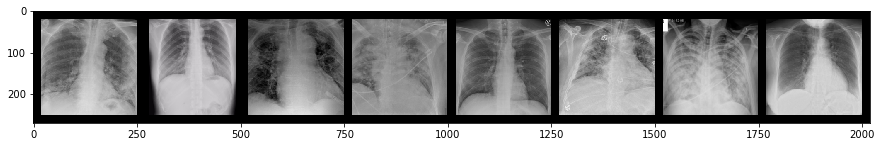

Class: NORMAL


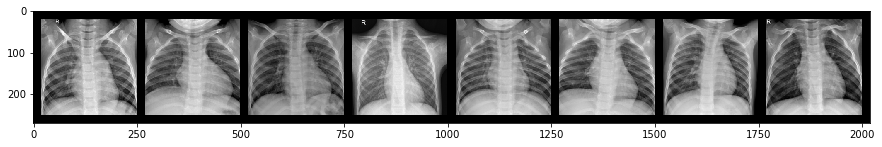

Class: PNEUMONIA


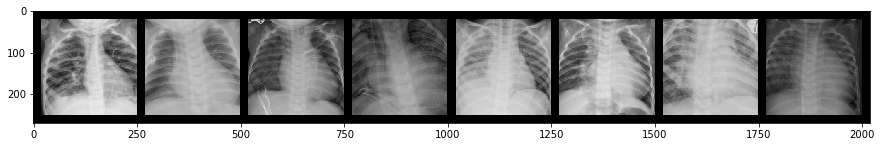

In [15]:
def show_batch_images(dataset):
    n_images, scale = 8, 3
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=25*n_images, shuffle = True)
    images, labels = next(iter(data_loader))
    for i in range(len(categories)):
        print(f'Class: {categories[i]}')
        images_category = images[labels==i][:n_images]
        grid = torchvision.utils.make_grid(images_category, padding=20)
        npgrid = grid.cpu().numpy()
        plt.figure(figsize=(40*scale/n_images, 20*scale/n_images))
        plt.imshow(np.transpose(npgrid, (1, 2, 0)), interpolation='nearest')
        plt.show()

show_batch_images(train_data)

### 4. Create the train, evaluate and test functions

In [4]:
def calc_metrics(predictions, actuals, row):
    df = pd.DataFrame(columns =metrics)
    Y_pred = np.concatenate(predictions, axis=0)
    Y_test = np.concatenate(actuals, axis=0)
    df.loc[row, 'Accuracy'] = accuracy_score(Y_test, Y_pred)
    df.loc[row, 'Precision'] = precision_score(Y_test, Y_pred, average="macro")
    df.loc[row, 'Recall'] = recall_score(Y_test, Y_pred, average="macro")
    df.loc[row, 'F1-score'] = f1_score(Y_test, Y_pred, average="macro")
    return df

def create_confusion_matrix(preds, y_test):
    ylist, predlist = [], []
    for pred in preds:
        for item in pred:
            predlist.append(int(item))
    for y in y_test:
        for item in y:
            ylist.append(int(item))
    data_dict = {'y_Actual':    ylist, 'y_Predicted': predlist}
    df = pd.DataFrame(data_dict, columns=['y_Actual','y_Predicted'])
    cm = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['ACTUAL'], colnames=['PREDICTED'])
    return cm

def train_val_model(model):
    t_start = time.time()
    df = pd.DataFrame(columns = ['model_name', 'epoch', 'train', 'validation'])
    print(f"Training model {model_name} with {df_dataset.loc['TOTAL', 'train']} samples and {n_epochs} epochs, and validating with {df_dataset.loc['TOTAL', 'val']} samples\n")
    train_size, val_size = len(train_loader), len(val_loader)
    for epoch in range(1, n_epochs+1):
        # Beginning of training step
        t0 = time.time()
        model.train()
        train_loss, val_loss = 0.0, 0.0
        for i, (data, target) in enumerate(train_loader):
            target = target.to(device)
            data = data.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.detach().cpu().numpy()
        # Beginning of evaluation step
        model.eval()
        for j, (data, target) in enumerate(val_loader):
            target = target.to(device)
            data = data.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.detach().cpu().numpy()
        print(f"Epoch {epoch}:\t train loss={train_loss/train_size:.5f} \t validation loss={val_loss/val_size:.5f} \t time={(time.time() - t0):.2f}s")
        df.loc[len(df)] = [model_name, epoch, train_loss/train_size, val_loss/val_size]
        if use_scheduler: scheduler.step(val_loss/val_size)   # Optional to use scheduler for dynamic learning rate
    print(f"Total time training and evaluating: {(time.time()-t_start):.2f}s")
    return model, df

def test_model(model):
    model.eval()
    print(f"Testing the model {model_name} with {df_dataset.loc['TOTAL', 'test']} samples \n")   
    predictions, actuals = [], []
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)
            Y_pred_orig = model(data)
            _, Y_pred_tag = torch.max(Y_pred_orig, dim = 1)
            Y_pred_tag = Y_pred_tag.detach().cpu().numpy()
            Y_pred_tag = Y_pred_tag.reshape(len(Y_pred_tag), 1).astype('int8')
            Y_test = target.detach().cpu().numpy()
            Y_test = Y_test.reshape(len(Y_test), 1).astype('int8')
            predictions.append(Y_pred_tag)
            actuals.append(Y_test)
    conf_matrix = create_confusion_matrix(predictions, actuals)
    df_test = calc_metrics(predictions, actuals, 'Test Results').astype(float)
    print(df_test)
    return df_test, conf_matrix

def plot_train_val_losses(df):
    df2 = pd.melt(df, id_vars=['epoch'], value_vars=['train', 'validation'], var_name='process', value_name='loss')
    sns.lineplot(x = "epoch", y = "loss", data = df2, hue = "process",
                style = "process", palette = "hot", dashes = False, 
                markers = ["o", "<"],  legend="brief").set_title("Train and Validation Losses by Epoch")
    plt.show()

### 5. Build our own model

#### 5.1 Build architecture of the model

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 128, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.pool1 = nn.MaxPool2d(kernel_size=4, stride=4)
        self.conv2 = nn.Conv2d(128, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear1 = nn.Linear(28 * 28 * 32, 256)
        self.linear2 = nn.Linear(256, 3)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout()
    def forward(self, x):
        x = self.pool1(self.relu(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu(self.bn2(self.conv2(x))))
        x = x.reshape(x.size(0), -1)
        x = self.relu(self.linear1(x))
        x = self.dropout(x)
        x = self.linear2(x)
        return x

#### 5.2 Define parameters of the model

In [7]:
net = Net().to(device)
model_name = 'DLH_team'
n_epochs = 20
learning_rate = 1e-2
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

#### 5.3 (optional) use scheduler for dynamic learning rate (see item 7 for train/test with the use of scheduler)

In [ ]:
use_scheduler = False   # Set True if using scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=0, threshold = 0.001, verbose=True, min_lr = 1e-5, threshold_mode = 'abs')

### 6. Train the model and save without scheduler

In [8]:
our_model, df_epochs = train_val_model(net)

Training model DLH_team with 5144 samples and 20 epochs, and validating with 643 samples

Epoch 1:	 train loss=0.39211 	 validation loss=0.30862 	 time=80.60s
Epoch 2:	 train loss=0.25634 	 validation loss=0.19818 	 time=81.31s
Epoch 3:	 train loss=0.22364 	 validation loss=0.19048 	 time=80.81s
Epoch 4:	 train loss=0.19474 	 validation loss=0.20397 	 time=80.53s
Epoch 5:	 train loss=0.18207 	 validation loss=0.18249 	 time=80.60s
Epoch 6:	 train loss=0.17482 	 validation loss=0.14146 	 time=80.25s
Epoch 7:	 train loss=0.15880 	 validation loss=0.16496 	 time=80.43s
Epoch 8:	 train loss=0.15232 	 validation loss=0.15951 	 time=80.45s
Epoch 9:	 train loss=0.14376 	 validation loss=0.13999 	 time=80.76s
Epoch 10:	 train loss=0.12567 	 validation loss=0.15014 	 time=80.61s
Epoch 11:	 train loss=0.13141 	 validation loss=0.12784 	 time=80.09s
Epoch 12:	 train loss=0.11527 	 validation loss=0.14970 	 time=81.21s
Epoch 13:	 train loss=0.10576 	 validation loss=0.25026 	 time=80.29s
Epoch 14:

In [69]:
torch.save(our_model.state_dict(), os.path.join(model_path, 'model.pth'))

#### 6.1 Plot epoch train and validation losses of the model

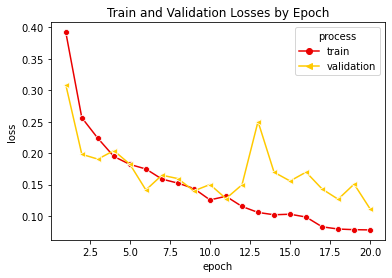

In [66]:
plot_train_val_losses(df_epochs)

#### 6.2 Test our own model

In [70]:
test_results, conf_matrix_test = test_model(our_model)

Testing the model DLH_team with 645 samples 

              Accuracy  Precision    Recall  F1-score
Test Results   0.96124   0.946067  0.961067  0.953354


#### 6.3 Show confusion matrix for test dataset

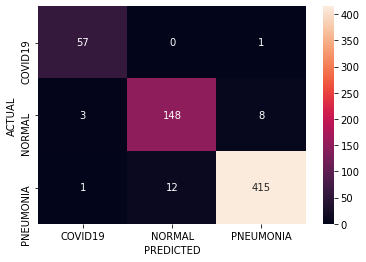

In [71]:
_ = sns.heatmap(conf_matrix_test, annot=True, fmt='g', xticklabels=categories, yticklabels=categories)

### 7. Train and validate the model using lr_scheduler (dynamic learning rate)

In [6]:
model_name = 'DLH_team'
net = Net().to(device)
learning_rate = 1e-2
n_epochs = 20
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
use_scheduler = True   # Set True if using scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=2, threshold = 0.001,
                                                 verbose=True, min_lr = 1e-5, threshold_mode = 'abs')
our_model, df_epochs = train_val_model(net)

Training model DLH_team with 5144 samples and 20 epochs, and validating with 643 samples

Epoch 1:	 train loss=0.39246 	 validation loss=0.21679 	 time=79.80s
Epoch 2:	 train loss=0.25879 	 validation loss=0.15142 	 time=79.58s
Epoch 3:	 train loss=0.22177 	 validation loss=0.21419 	 time=79.94s
Epoch 4:	 train loss=0.19590 	 validation loss=0.19588 	 time=80.03s
Epoch 5:	 train loss=0.18064 	 validation loss=0.15220 	 time=80.16s
Epoch     5: reducing learning rate of group 0 to 5.0000e-03.
Epoch 6:	 train loss=0.14470 	 validation loss=0.19380 	 time=80.05s
Epoch 7:	 train loss=0.13410 	 validation loss=0.15434 	 time=80.05s
Epoch 8:	 train loss=0.12666 	 validation loss=0.14823 	 time=80.02s
Epoch 9:	 train loss=0.11860 	 validation loss=0.15643 	 time=81.19s
Epoch 10:	 train loss=0.11024 	 validation loss=0.11601 	 time=80.31s
Epoch 11:	 train loss=0.10946 	 validation loss=0.13221 	 time=80.14s
Epoch 12:	 train loss=0.10106 	 validation loss=0.13410 	 time=80.94s
Epoch 13:	 train 

#### 7.1 Plot epoch train and validation losses of the model

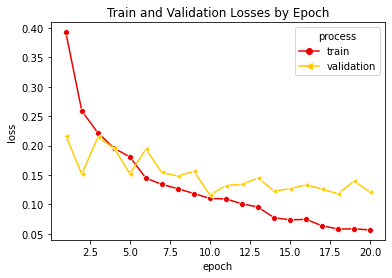

In [9]:
plot_train_val_losses(df_epochs)

#### 7.2 Test our own model

In [18]:
test_results, conf_matrix_test = test_model(our_model)

              Accuracy  Precision    Recall  F1-score
Test Results  0.958085   0.951695  0.938846  0.945137


#### 7.3 Show confusion matrix for test dataset

In [ ]:
_ = sns.heatmap(conf_matrix_test, annot=True, fmt='g', xticklabels=categories, yticklabels=categories)

### 8 (Optional) load a model already saved

In [6]:
model_name = 'DLH_team'
our_model = Net().to(device)  
our_model.load_state_dict(torch.load(os.path.join(model_path, 'model.pth')))  
_ = our_model.eval()